In [2]:
""" stacked LSTM """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
rain_data = pd.read_csv('rain_day.csv', encoding='utf-8')
dam_data = pd.read_csv('total_dam.csv', encoding='utf-8')

In [4]:
dam_data = dam_data.drop('Unnamed: 0', axis = 1)

In [5]:
data = []

In [6]:
data = pd.merge( dam_data,rain_data, on='date', how='inner')

In [7]:
data = data.fillna(0)

In [8]:
print(data)

             date     dam    90  100  101  211  212
0      1974-01-01  10.000   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   9.000   0.0  0.0  0.0  0.0  0.0
2      1974-01-03   4.800   0.0  0.0  0.0  0.0  0.0
3      1974-01-04   6.100   0.0  0.0  0.0  0.0  0.0
4      1974-01-05   5.800   0.0  0.0  0.0  0.0  0.0
...           ...     ...   ...  ...  ...  ...  ...
18257  2023-12-27  25.873   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28  21.186   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29  20.887   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30  29.183   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31  25.803  26.8  6.0  5.3  3.1  4.9

[18262 rows x 7 columns]


In [9]:
# save original 'Open' prices for later
original_dam = data['dam'].values

In [10]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [11]:
print(data)

             date     dam    90  100  101  211  212
0      1974-01-01  10.000   0.0  0.0  0.0  0.0  0.0
1      1974-01-02   9.000   0.0  0.0  0.0  0.0  0.0
2      1974-01-03   4.800   0.0  0.0  0.0  0.0  0.0
3      1974-01-04   6.100   0.0  0.0  0.0  0.0  0.0
4      1974-01-05   5.800   0.0  0.0  0.0  0.0  0.0
...           ...     ...   ...  ...  ...  ...  ...
18257  2023-12-27  25.873   0.0  0.0  0.0  0.0  0.0
18258  2023-12-28  21.186   0.0  0.0  0.0  0.0  0.0
18259  2023-12-29  20.887   0.0  0.0  0.0  0.0  0.0
18260  2023-12-30  29.183   0.7  2.3  9.9  6.8  8.5
18261  2023-12-31  25.803  26.8  6.0  5.3  3.1  4.9

[18262 rows x 7 columns]


In [12]:
# variables for training
cols = list(data)[1:7]

In [13]:
print(cols)

['dam', '90', '100', '101', '211', '212']


In [14]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [15]:
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(data)
dam_data_scaled = scaler.transform(data)

In [16]:
dam = dam_data.drop('date', axis= 1)

scaler_dam = StandardScaler()
dam_scaled = scaler_dam.fit_transform(dam)

In [17]:
print(dam_data_scaled[:15])

[[-0.26438616 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26891176 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.28791927 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.28203599 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.28339367 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.27026944 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26710152 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.27886808 -0.26757136 -0.25971438 -0.26170736 -0.26126318 -0.26448106]
 [-0.28158343 -0.25354633 -0.24107284 -0.26170736 -0.26126318 -0.26448106]
 [-0.29380255 -0.26757136 -0.25350053 -0.26170736 -0.26126318 -0.26448106]
 [-0.28656159 -0.26055885 -0.24107284 -0.26170736 -0.26126318 -0.26448106]
 [-0.28927695 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.28022575 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.28067831 -0.26757136

In [18]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

16435   2018-12-31
16436   2019-01-01
16437   2019-01-02
16438   2019-01-03
16439   2019-01-04
Name: date, dtype: datetime64[ns]


In [19]:
print(train_data_scaled[13])

[-0.28067831 -0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]


In [20]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 14   # sequence length = past days for future prediction.
input_dim = 5  # input_dimension = ['90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 1:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 2:i + pred_days-1, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 1:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 2:i + pred_days-1, 0])

print(trainX[0])
print(trainY[0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

[[-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.25971438 -0.26170736 -0.26126318 -0.26448106]
 [-0.25354633 -0.24107284 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.25350053 -0.26170736 -0.26126318 -0.26448106]
 [-0.26055885 -0.24107284 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
 [-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]]
[-0.28067831]


In [21]:
print(trainY)

[[-0.28067831]
 [-0.26936432]
 [-0.28429879]
 ...
 [-0.28466084]
 [-0.28400915]
 [-0.28364258]]


In [22]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(16421, 14, 5) (16421, 1)
(1813, 14, 5) (1813, 1)


In [23]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [25]:
# Try to load weights
try:
    model.load_weights('dam_lstm_nodam_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('dam_lstm_nodam_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

Loaded model weights from disk


57/57 [==============================] - 1s 2ms/step
(1813, 1) (1813, 1)
(1813,)


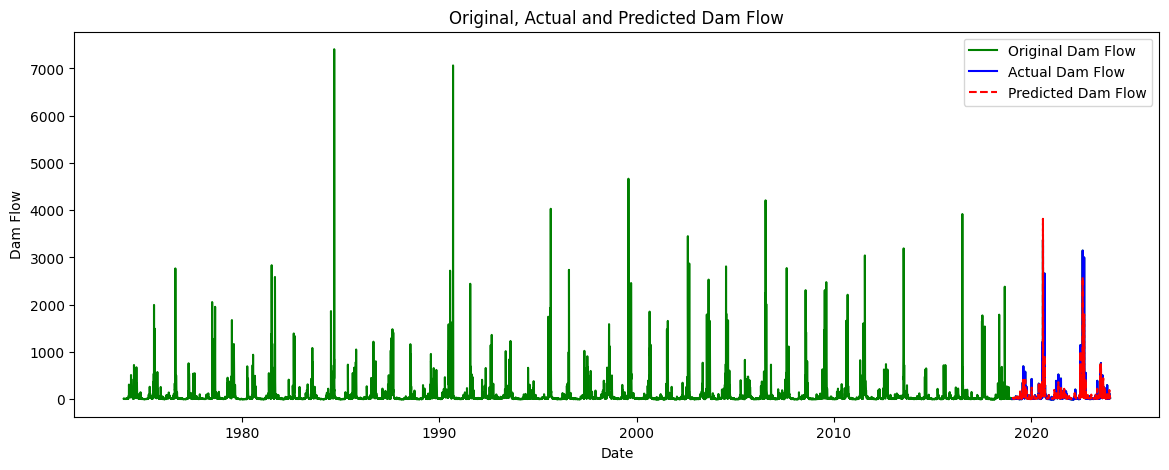

In [26]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

# generate array filled with means for prediction
mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# substitute predictions into the first column
mean_values_pred[:, 0] = np.squeeze(prediction)

# inverse transform
y_pred = scaler.inverse_transform(mean_values_pred)[:,0]

# generate array filled with means for testY
mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# substitute testY into the first column
mean_values_testY[:, 0] = np.squeeze(testY)

# inverse transform
testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
print(testY_original.shape)

# plotting
plt.figure(figsize=(14, 5))

# plot original 'Open' prices
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [27]:
print(test_dates)

16435   2018-12-31
16436   2019-01-01
16437   2019-01-02
16438   2019-01-03
16439   2019-01-04
           ...    
18257   2023-12-27
18258   2023-12-28
18259   2023-12-29
18260   2023-12-30
18261   2023-12-31
Name: date, Length: 1827, dtype: datetime64[ns]


In [28]:
testDates = []
for day in test_dates[14:]:
  testDates.append(day.strftime("%Y-%m-%d"))

testDates = pd.DataFrame(testDates)
pred_y = pd.DataFrame(y_pred)
origin_y = pd.DataFrame(testY_original)

lstm_include_dam = pd.concat([testDates, origin_y, pred_y], axis = 1)
print(lstm_include_dam)

lstm_include_dam = pd.DataFrame(lstm_include_dam)
lstm_include_dam.to_csv("data/lstm_notinclude_dam.csv")

               0       0          0
0     2019-01-14   9.100  16.055030
1     2019-01-15   3.300  16.055030
2     2019-01-16   9.100  16.071414
3     2019-01-17   3.200  16.064618
4     2019-01-18   9.100  16.059324
...          ...     ...        ...
1808  2023-12-27  30.518  25.292755
1809  2023-12-28  25.873  27.502933
1810  2023-12-29  21.186  24.849961
1811  2023-12-30  20.887  17.375405
1812  2023-12-31  29.183  18.539735

[1813 rows x 3 columns]


In [29]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler_dam.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

lstm_notinclude_x = pd.concat([testDates, testX_last, origin_y, pred_y], axis = 1)
lstm_notinclude_x.to_csv("data/lstm_notinclude_x.csv")

print(lstm_notinclude_x)

[-0.26757136 -0.27835591 -0.26170736 -0.26126318 -0.26448106]
               0          0          1           2           3           4  \
0     2019-01-14   9.296183   6.913170   10.591923   10.690071    9.979031   
1     2019-01-15   9.296183   6.913170   10.591923   10.690071    9.979031   
2     2019-01-16   9.296183   6.913170   13.805890   10.690071    9.979031   
3     2019-01-17   9.296183   6.913170   12.198907   10.690071    9.979031   
4     2019-01-18   9.296183   6.913170   10.591923   10.690071    9.979031   
...          ...        ...        ...         ...         ...         ...   
1808  2023-12-27   9.296183   6.913170   10.591923   10.690071    9.979031   
1809  2023-12-28   9.296183   6.913170   10.591923   10.690071    9.979031   
1810  2023-12-29   9.296183   6.913170   10.591923   10.690071    9.979031   
1811  2023-12-30   9.296183   6.913170   10.591923   10.690071    9.979031   
1812  2023-12-31  20.142836  38.493189  169.683250  132.780095  147.329733   

 

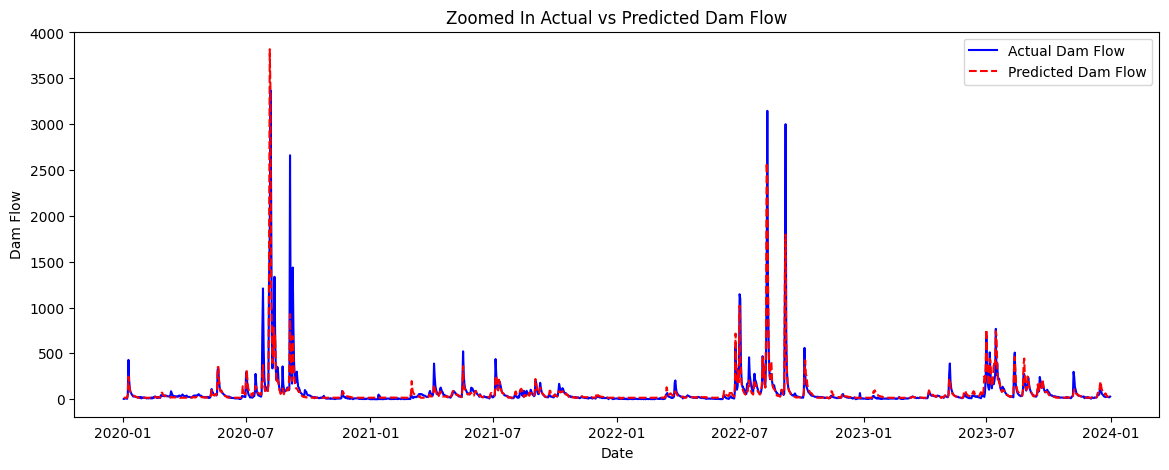

In [36]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 365*4
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

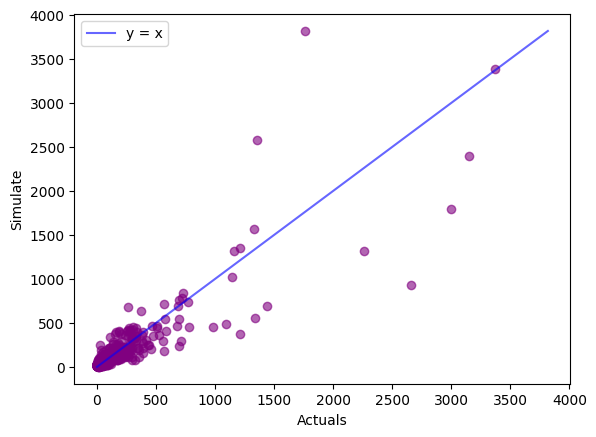

In [31]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [32]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 98.32


In [33]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.754890


In [34]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : -0.914524


In [35]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.758454
